In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam, SGD
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import pickle

In [5]:
#data frame with the filtered topic labels and features that characterize each data entry:

file = open("tfidf_topics.pkl",'rb')
df = pickle.load(file)
file.close()


Text(0, 0.5, 'Number of topics')

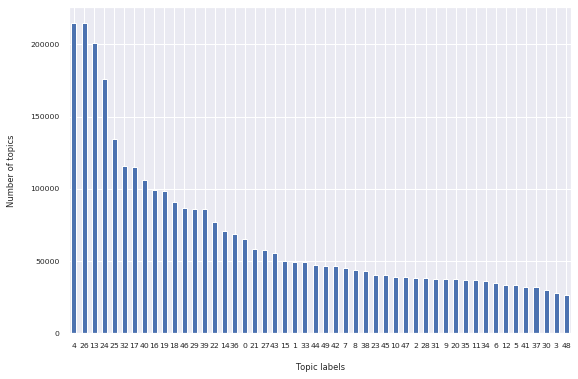

In [6]:
sns.set(font_scale=0.7)
df['text_tokens'].value_counts().plot(kind='bar', figsize=(9, 6), rot=0)
plt.xlabel("Topic labels", labelpad=14)
plt.ylabel("Number of topics", labelpad=14)
#plt.title("Histogram showing frequency of topics in the dataset", y=1.02);

In [7]:
#Tweet count for all the users considered
df['engaging_user_id'].value_counts()

72C2BE10D3673447A6D596E12C0523DA    502
3396F36ADFF2A01A34C0CB3486CABFEE    388
5049F4AC51D668D064214377EB38A8D3    320
3FC1A3B3B9C8D1BD6673C3B5B65A6E91    308
F1D8FA7C91B5EE653330E80D48C77AD1    297
                                   ... 
99182399BD0A2044EFE905F6F90D5278     21
25DDB40147D5A0267158FF2142B5BA74     21
3DF7577EA3128788FE3834E676DD25F9     21
DD982926F3C94DF49972A1843CA6E706     21
1B776436E2C4E41CA201A14F7439CEA0     21
Name: engaging_user_id, Length: 107017, dtype: int64

In [8]:
#Convert date to yyyy-mm-dd hh:mm:ss format
import datetime
df['tweet_timestamp'] = df["tweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x)) 

In [9]:
t1 = df[(df["tweet_timestamp"] >= '2020-02-05 18:00:00') & (df["tweet_timestamp"] < '2020-02-06 06:00:00')]
t2 = df[(df["tweet_timestamp"] >= '2020-02-06 06:00:00') & (df["tweet_timestamp"] < '2020-02-06 18:00:00')]
t3 = df[(df["tweet_timestamp"] >= '2020-02-06 18:00:00') & (df["tweet_timestamp"] < '2020-02-07 06:00:00')]
t4 = df[(df["tweet_timestamp"] >= '2020-02-07 06:00:00') & (df["tweet_timestamp"] < '2020-02-07 18:00:00')]
t5 = df[(df["tweet_timestamp"] >= '2020-02-07 18:00:00') & (df["tweet_timestamp"] < '2020-02-08 06:00:00')]
t6 = df[(df["tweet_timestamp"] >= '2020-02-08 06:00:00') & (df["tweet_timestamp"] < '2020-02-08 18:00:00')]
t7 = df[(df["tweet_timestamp"] >= '2020-02-08 18:00:00') & (df["tweet_timestamp"] < '2020-02-09 06:00:00')]
t8 = df[(df["tweet_timestamp"] >= '2020-02-09 06:00:00') & (df["tweet_timestamp"] < '2020-02-09 18:00:00')]
t9 = df[(df["tweet_timestamp"] >= '2020-02-09 18:00:00') & (df["tweet_timestamp"] < '2020-02-10 06:00:00')]
t10 = df[(df["tweet_timestamp"] >= '2020-02-10 06:00:00') & (df["tweet_timestamp"] < '2020-02-10 18:00:00')]
t11 = df[(df["tweet_timestamp"] >= '2020-02-10 18:00:00') & (df["tweet_timestamp"] < '2020-02-11 06:00:00')]
t12 = df[(df["tweet_timestamp"] >= '2020-02-11 06:00:00') & (df["tweet_timestamp"] < '2020-02-11 18:00:00')]
t13 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
t14 = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]

# Each time period is 12 hrs
# Engagement frequency of user is from time periods t1 to t12 during training
# Recent history of user is considered from time periods t9 to t12 training 
# Current time period is considered as t13
# Testing will be carried out on time period t14


In [10]:


columns = ['reply_timestamp','tweet_timestamp', 'tweet_id',"retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]


In [11]:
#Recent history t9 to t12 for training

t9['retweet'] = np.where(pd.notnull(t9['retweet_timestamp']), 1, 0)
t9.drop(columns, axis=1,inplace=True)
t_9 = t9.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t9_history = t_9.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t9_history.fillna(0,inplace = True)
history_t9 = pd.DataFrame(t9_history.to_records())
for col in history_t9.columns:
  if col != 'engaging_user_id':
    history_t9.loc[history_t9[col] > 1, col] = 1

t10['retweet'] = np.where(pd.notnull(t10['retweet_timestamp']), 1, 0)
t10.drop(columns, axis=1,inplace=True)
t_10 = t10.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t10_history = t_10.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t10_history.fillna(0,inplace = True)
history_t10 = pd.DataFrame(t10_history.to_records())
for col in history_t10.columns:
  if col != 'engaging_user_id':
    history_t10.loc[history_t10[col] > 1, col] = 1

t11['retweet'] = np.where(pd.notnull(t11['retweet_timestamp']), 1, 0)
t11.drop(columns, axis=1,inplace=True)
t_11 = t11.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t11_history = t_11.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t11_history.fillna(0,inplace = True)
history_t11 = pd.DataFrame(t11_history.to_records())
for col in history_t11.columns:
  if col != 'engaging_user_id':
    history_t11.loc[history_t11[col] > 1, col] = 1


t12['retweet'] = np.where(pd.notnull(t12['retweet_timestamp']), 1, 0)
t12.drop(columns, axis=1,inplace=True)
t_12 = t12.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t12_history = t_12.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t12_history.fillna(0,inplace = True)
history_t12 = pd.DataFrame(t12_history.to_records())
for col in history_t12.columns:
  if col != 'engaging_user_id':
    history_t12.loc[history_t12[col] > 1, col] = 1

    
t13['retweet'] = np.where(pd.notnull(t13['retweet_timestamp']), 1, 0)
t13.drop(columns, axis=1,inplace=True)
t_13 = t13.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t13_history = t_13.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t13_history.fillna(0,inplace = True)
history_t13 = pd.DataFrame(t13_history.to_records())
for col in history_t13.columns:
  if col != 'engaging_user_id':
    history_t13.loc[history_t13[col] > 1, col] = 1


t14['retweet'] = np.where(pd.notnull(t14['retweet_timestamp']), 1, 0)
t14.drop(columns, axis=1,inplace=True)
t_14 = t14.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
test_info = t_14.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
test_info.fillna(0,inplace = True)
test = pd.DataFrame(test_info.to_records())
for col in test.columns:
  if col != 'engaging_user_id':
    test.loc[test[col] > 1, col] = 1    

In [12]:
#Engagement frequency for testing time
eng_frequency = df[df["tweet_timestamp"] < '2020-02-12 6:00:00']
eng_frequency['retweet'] = np.where(pd.notnull(eng_frequency['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency.drop(columns, axis=1,inplace=True)
engagement_history = eng_frequency.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history = engagement_history.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history.fillna(0,inplace = True)
history_frequency = pd.DataFrame(input_engagement_history.to_records())

In [13]:
#Engagement frequency for training time
eng_frequency_train = df[df["tweet_timestamp"] < '2020-02-11 18:00:00']
eng_frequency_train['retweet'] = np.where(pd.notnull(eng_frequency_train['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency_train.drop(columns, axis=1,inplace=True)
engagement_history_train = eng_frequency_train.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history_train = engagement_history_train.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history_train.fillna(0,inplace = True)
history_frequency_train = pd.DataFrame(input_engagement_history_train.to_records())

In [14]:

left_out_rows_t9 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t9['engaging_user_id'])]
for col in left_out_rows_t9.columns:
    if col != 'engaging_user_id':
        left_out_rows_t9[col].values[:] = 0
final_history_t9 = history_t9.append(left_out_rows_t9)
final_history_t9 = final_history_t9.sort_values('engaging_user_id')
final_history_t9.reset_index(drop=True, inplace=True)

left_out_rows_t10 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t10['engaging_user_id'])]
for col in left_out_rows_t10.columns:
    if col != 'engaging_user_id':
        left_out_rows_t10[col].values[:] = 0
final_history_t10 = history_t10.append(left_out_rows_t10)
final_history_t10 = final_history_t10.sort_values('engaging_user_id')
final_history_t10.reset_index(drop=True, inplace=True)

left_out_rows_t11 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t11['engaging_user_id'])]
for col in left_out_rows_t11.columns:
    if col != 'engaging_user_id':
        left_out_rows_t11[col].values[:] = 0
final_history_t11 = history_t11.append(left_out_rows_t11)
final_history_t11 = final_history_t11.sort_values('engaging_user_id')
final_history_t11.reset_index(drop=True, inplace=True)


left_out_rows_t12 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t12['engaging_user_id'])]
for col in left_out_rows_t12.columns:
    if col != 'engaging_user_id':
        left_out_rows_t12[col].values[:] = 0
final_history_t12 = history_t12.append(left_out_rows_t12)
final_history_t12 = final_history_t12.sort_values('engaging_user_id')
final_history_t12.reset_index(drop=True, inplace=True)


In [15]:

#label for training
left_out_rows_t13 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t13['engaging_user_id'])]
for col in left_out_rows_t13.columns:
    if col != 'engaging_user_id':
        left_out_rows_t13[col].values[:] = 0
final_history_t13 = history_t13.append(left_out_rows_t13)
final_history_t13 = final_history_t13.sort_values('engaging_user_id')
final_history_t13.reset_index(drop=True, inplace=True)

#label for testing
left_out_rows = history_frequency[~history_frequency['engaging_user_id'].isin(test['engaging_user_id'])]
for col in left_out_rows.columns:
    if col != 'engaging_user_id':
        left_out_rows[col].values[:] = 0
final_test = test.append(left_out_rows)
final_test = final_test.sort_values('engaging_user_id')
final_test.reset_index(drop=True, inplace=True)        

In [16]:
#dataframes with engagement histories  
from functools import reduce
recent_history = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history_t9, final_history_t10, final_history_t11, final_history_t12])
recent_history_test = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history_t10, final_history_t11, final_history_t12, final_history_t13])

In [17]:
history_frequency = history_frequency.sort_values('engaging_user_id')
history_frequency_train = history_frequency_train.sort_values('engaging_user_id')

In [18]:
#topic recommendations generation for training and testing.

time = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]
left = time[time['retweet_timestamp'] >= 0]
time['retweet_timestamp'].fillna(0,inplace=True)

left['retweet_timestamp'] = left["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
time = pd.concat([time,left]).drop_duplicates(keep=False)
time['retweet_timestamp'] = time['tweet_timestamp']
final = pd.concat([time,left])

final = final.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
final = final.reset_index(drop=True)

columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
final.drop(columns, axis=1,inplace=True)


time_1 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
left_1 = time_1[time_1['retweet_timestamp'] >= 0]
time_1['retweet_timestamp'].fillna(0,inplace=True)

left_1['retweet_timestamp'] = left_1["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
time_1 = pd.concat([time_1,left_1]).drop_duplicates(keep=False)
time_1['retweet_timestamp'] = time_1['tweet_timestamp']
initial = pd.concat([time_1,left_1])

initial = initial.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
initial = initial.reset_index(drop=True)

columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
initial.drop(columns, axis=1,inplace=True)

In [20]:
# We consider the positive examples for topic recommendations from all the tweets posted during the active states and vice versa. 
# An active state is defined as a period between when a tweet is published and engaged


#Function action_recommend for determining the active states
def active_recommend(x):
    g = 3
    for index, row in x.iterrows():
      if g != 10 :
        a = row['engaging_user_id']
        b = row['tweet_timestamp']
        c = row['retweet_timestamp']
        p = 0
        if b != c :
          g = 10
      if (row['tweet_timestamp'] != row['retweet_timestamp']):
          p = 1
          d = row['engaging_user_id']
          e = row['tweet_timestamp']
          f = row['retweet_timestamp']
      elif row['tweet_timestamp'] == row['retweet_timestamp']:
          if row['engaging_user_id'] == a:
            p = 0
          elif row['engaging_user_id'] == d:
            if (row['tweet_timestamp'] >= e) & (row['tweet_timestamp'] <= f):
              p = 1
            else:
              p = 0
      x.loc[index,'recommend'] = p
    return final
    }
final = active_recommend(final)    # Test Recommendations 
inital = active_recommend(initial) # Training Recommendations

In [21]:
final['recommend'].value_counts()

1.0    287758
0.0    105948
Name: recommend, dtype: int64

In [22]:
initial['recommend'].value_counts()

1.0    221141
0.0     71676
Name: recommend, dtype: int64

In [ ]:
column = ['tweet_timestamp','retweet_timestamp']
final.drop(column, axis=1,inplace=True)
initial.drop(column, axis=1,inplace=True)

In [ ]:

final_1 = final.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
final_2 = final_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
final_2.fillna(0,inplace = True)
final_3 = pd.DataFrame(final_2.to_records())

for col in final_3.columns:
  if col != 'engaging_user_id':
    final_3.loc[final_3[col] > 1, col] = 1
    
    
left_out_rows_f = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
for col in left_out_rows_f.columns:
    if col != 'engaging_user_id':
        left_out_rows_f[col].values[:] = 0
final_4 = final_3.append(left_out_rows_f)
recommend_test = final_4.sort_values('engaging_user_id')
recommend_test.reset_index(drop=True, inplace=True)  #Dataframe with topic recommendation during testing

In [ ]:
initial_1 = initial.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
initial_2 = initial_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
initial_2.fillna(0,inplace = True)
initial_3 = pd.DataFrame(final_2.to_records())

for col in initial_3.columns:
  if col != 'engaging_user_id':
    initial_3.loc[final_3[col] > 1, col] = 1
    
left_out_rows_g = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
for col in left_out_rows_g.columns:
    if col != 'engaging_user_id':
        left_out_rows_f[col].values[:] = 0
initial_4 = initial_3.append(left_out_rows_f)
recommend = initial_4.sort_values('engaging_user_id')
recommend.reset_index(drop=True, inplace=True)      #Dataframe with topic recommendation during training
    

In [ ]:
X_recent_2 = recent_history.drop('engaging_user_id', axis=1).values
X_recent_1 = X_recent_2.reshape(-1,50,4)

X_recent_2_test = recent_history_test.drop('engaging_user_id', axis=1).values
X_recent_1_test = X_recent_2_test.reshape(-1,50,4)



X_freq_1 = history_frequency.drop('engaging_user_id', axis=1).values
X_freq_1_train = history_frequency_train.drop('engaging_user_id', axis=1).values


X_recommend_1 = recommend.drop('engaging_user_id', axis=1).values
X_recommend_t = recommend_test.drop('engaging_user_id', axis=1).values

y_1 = final_history_t13.drop('engaging_user_id', axis=1).values

y_t = final_test.drop('engaging_user_id', axis=1).values

#INPUTS



In [ ]:
X_recent = torch.FloatTensor(X_recent_1)              #Recent Engagement History tensor input for training
X_freq = torch.FloatTensor(X_freq_1_train)            #Engagement Frequency tensor input for training
X_recommend = torch.FloatTensor(X_recommend_1)        #Topic Recommendation tensor input for training
y = torch.FloatTensor(y_1)                            #Engagement output tensor input for training


X_recent_test = torch.FloatTensor(X_recent_1_test)    #Recent Engagement History tensor input for testing
X_freq_test = torch.FloatTensor(X_freq_1)             #Engagement Frequency tensor input for testing
X_recommend_test = torch.FloatTensor(X_recommend_t)   #Topic Recommendation tensor input for testing
Y_test = torch.FloatTensor(y_t)                       #Engagement output tensor input for training

In [ ]:
X_freq = F.normalize(X_freq, p=2, dim=1)              #Normalized Engagement Frequency tensor input for training
X_freq_test = F.normalize(X_freq_test, p=2, dim=1)    #Normalized Engagement Frequency tensor input for testing

In [ ]:
final_test['1'].value_counts()
b = []
for i in range(50):
      b.append(final_history_t13[str(i)].sum())
np.array(b)
c = 107017*np.ones((50))
weights  = torch.tensor((c-np.array(b))/np.array(b))

In [ ]:
filters = 20
L = 10
class DNN_f(nn.Module):
    def __init__(self):
        super().__init__()
        #frequency input
        self.fc1 = nn.Linear(in_features=50, out_features=L)

        #history input 32 * 50 * 4
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
        self.leaky = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
        self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


        #recommend input
        self.fc3 = nn.Linear(in_features=50, out_features=L)
        
        #final linear
        self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
        self.fc4 = nn.Linear(in_features=45, out_features=1)

 
    def forward(self, x, y, z, a):
        x1 = self.fc1(x)      ### EH
        x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
        y_ = y.view(-1,1,50,4)
        y1 = self.conv1(y_)
        y1 = self.leaky(y1)
        y2 = y1.view(-1,50,filters)   ####   ET       
        y1 = self.conv2(y1)
        y1 = self.conv3(y1)
        y3 = y1.view(-1,50,filters)   ####   ETBAR
        print(y.shape)
        print(y2.shape)
        
        z1 = self.fc3(z)    ####  DT
        z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
        w = torch.stack((x, x2,z, z2), dim=2)
        v = torch.cat((y2,y3),dim =2)
        u = torch.cat((w,v),dim=2)
        a = a.view(-1,50,1)
        r = torch.cat((a,u),dim = 2)
        
        #r = r.view(-1,1,50,5+2*(filters))
        #t = self.conv4(r)
        #s = t.view(-1,50)
        
        r = r.view(-1,50,5+2*(filters))
        print(r.shape)
        t = self.fc4(r)
        s = t.view(-1,50)

        return s

In [ ]:
filters = 20
L = 10
class DNN_l(nn.Module):
    def __init__(self):
        super().__init__()
        #frequency input
        self.fc1 = nn.Linear(in_features=50, out_features=L)

        #history input 32 * 50 * 4
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
        self.leaky = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
        self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


        #recommend input
        self.fc3 = nn.Linear(in_features=50, out_features=L)
        
        #final linear
        self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
        self.fc4 = nn.Linear(in_features=49, out_features=500)
        
        self.fc5 = nn.Linear(in_features=500, out_features=100)
        
        self.fc6 = nn.Linear(in_features=100, out_features=1)
        
        

 
    def forward(self, x, y, z, a):
        x1 = self.fc1(x)      ### EH
        x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
        y_ = y.view(-1,1,50,4)
        y1 = self.conv1(y_)
        y1 = self.leaky(y1)
        y2 = y1.view(-1,50,filters)   ####   ET       
        y1 = self.conv2(y1)
        y1 = self.conv3(y1)
        y3 = y1.view(-1,50,filters)   ####   ETBAR
        
        z1 = self.fc3(z)    ####  DT
        z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
        w = torch.stack((x, x2,z, z2), dim=2)
        v = torch.cat((y2,y3),dim =2)
        u = torch.cat((w,v),dim=2)
        a = a.view(-1,50,1)
        r = torch.cat((a,u),dim = 2)
        
        #r = r.view(-1,50,5+2*(filters))
        #r = torch.cat((r,y),dim=2)
        #r = r.view(-1,1,50,5+2*(filters))
        #t = self.conv4(r)
        #s = t.view(-1,50)
        
        
        r = r.view(-1,50,5+2*(filters))
        r = torch.cat((r,y),dim=2)
        t = self.fc4(r)
        t = self.fc5(t)
        t = self.fc6(t)
        s = t.view(-1,50)

        return s

In [ ]:
torch.ones([32, 50], dtype=torch.float64).shape

In [ ]:
model = DNN_f()
model = model.to(device)

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-5)
#loss_func = nn.BCEWithLogitsLoss(pos_weight = weights, reduction = 'sum').cuda()
loss_func = nn.BCEWithLogitsLoss().cuda()

BATCH_SIZE = 32
train_loss = 0
losses = []
steps = []
step = 0
count = 0
EPOCHS = 50

In [ ]:
X_indicator = torch.ones([107017, 50])
import time
start_time = time.time()
train_dataset = TensorDataset(X_freq, X_recent, X_recommend, y, X_indicator)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
print ("--- %s seconds ---" % (time.time() - start_time))


for epoch_num in range(EPOCHS):
    model.train()
    for step_num, batch_data in enumerate(train_dataloader):
        freq, recent, recommend, labels, indicator = tuple(t.to(device)for t in batch_data)
        probas = model(freq, recent, recommend, indicator)
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()

        model.zero_grad()
        batch_loss.backward()


        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(y)/BATCH_SIZE, train_loss / (count + 1)))
        print ("--- %s seconds ---" % (time.time() - start_time))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1
        count += 1


In [ ]:


#torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

#model = describe_model()
#checkpoint = torch.load('checkpoint.pth.tar')
#model.load_state_dict(checkpoint['state_dict'])

In [ ]:
model.eval()

with torch.no_grad():

    logits_train = model(X_freq.to(device), X_recent.to(device), X_recommend.to(device), X_indicator.to(device)).to('cpu')
    logits_test = model(X_freq_test.to(device), X_recent_test.to(device), X_recommend_test.to(device), X_indicator.to(device)).to('cpu')
    numpy_logits_train = logits_train.detach().numpy()
    numpy_logits_test = logits_test.detach().numpy()
    
        

In [ ]:
import numpy as np
import math

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)


In [ ]:
#Converting logits to probabilities
numpy_probas_test = sigmoid_v(numpy_logits_test)
numpy_probas_train = sigmoid_v(numpy_logits_train)

In [ ]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),numpy_probas_test)

In [ ]:
#Performance Metrics          
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result





In [ ]:
thresh = []
roc = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), numpy_probas_test[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    roc.append(roc_auc)
    thresh.append(optimal_threshold)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
sum(roc)/50

In [ ]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

for i in range(50):
    numpy_probas_test[:,i] = to_labels(numpy_probas_test[:,i],thresh[i])

In [ ]:
scores = []
for i in range(50):
    scores.append(binary_classification_performance(Y_test[:,i].numpy(),numpy_probas_test[:,i]))

In [ ]:
f = pd.concat(scores)

In [ ]:
f.mean(axis=0)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), numpy_probas_test)

# Binary Logits

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Converting engagement frequencies from tensor to numpy array

X_freq_1 = X_freq.numpy()
X_freq_1_test = X_freq_test.numpy()


In [ ]:
empty_train_p = []
empty_test_p = []
for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]     #Engagement history by topic as input for training
    freq_lm_train = X_freq_1[:,i]                            #Engagement frequncy by topic as input for training
    recommend_lm_train = X_recommend_1[:,i]                  #Recommendations by topic as input for training
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]] #Engagement history by topic as input for testing
    freq_lm_test = X_freq_1_test[:,i]                        #Engagement frequncy by topic as input for testing
    recommend_lm_test = X_recommend_t[:,i]                   #Recommendations by topic as input for testing


    y_lm_train = y_1[:,i]                                    #Engagement labels

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])  #Concatenated input features for training

    #LR = LogisticRegression(class_weight="balanced")
    LR = LogisticRegression()

    LR.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test]) #Concatenated input features for testing
    
    empty_train_p.append((LR.predict_proba(X)[:,1]))
       
    empty_test_p.append((LR.predict_proba(X_test)[:,1]))
      

In [ ]:
prediction_lr_train_p = np.transpose(np.array(empty_train_p))  #Predictions for training data
prediction_lr_test_p = np.transpose(np.array(empty_test_p))    #Predictions for test data

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_t,prediction_lr_test_p)

In [ ]:
thresh_lr = []
roc_lr = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lr_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    thresh_lr.append(optimal_threshold)
    roc_lr.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [ ]:
sum(roc_lr)/50  #Average AUC-ROC score 

In [ ]:
for i in range(50):
    prediction_lr_test_p[:,i] = to_labels(prediction_lr_test_p[:,i],thresh_lr[i])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), prediction_lr_test_p)


In [ ]:
scores_lr = []
for i in range(50):
    scores_lr.append(binary_classification_performance(Y_test[:,i].numpy(),prediction_lr_test_p[:,i]))

In [ ]:
f_lr = pd.concat(scores_lr)

In [ ]:
f_lr.mean(axis=0)

# Light GBM model

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [ ]:
empty_train_1p = []
empty_test_1p = []


for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]
    freq_lm_train = X_freq_1[:,i]
    recommend_lm_train = X_recommend_1[:,i]
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]]
    freq_lm_test = X_freq_1_test[:,i]
    recommend_lm_test = X_recommend_t[:,i]


    y_lm_train = y_1[:,i]
    

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])

    LGBM = LGBMClassifier()

    LGBM.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test])
    
    empty_train_1.append(LGBM.predict(X))
    
    empty_train_1p.append((LGBM.predict_proba(X)[:,0]))

    empty_test_1.append(LGBM.predict(X_test))
    
    empty_test_1p.append((LGBM.predict_proba(X_test)[:,0]))
        


In [ ]:
prediction_lgbm_train = np.transpose(np.array(empty_train_1))
prediction_lgbm_test = np.transpose(np.array(empty_test_1))

prediction_lgbm_train_p = np.transpose(np.array(empty_train_1p))
prediction_lgbm_test_p = np.transpose(np.array(empty_test_1p))

In [ ]:
# prediction_lgbm_test_p
#with open('prediction_lgbm_test_p_bce.pkl','wb') as f:
#      pickle.dump(prediction_lgbm_test_p, f)

In [ ]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),prediction_lgbm_test_p)

In [ ]:
thresh_lgbm = []
roc_lgbm = []
for i in range(50):    
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    #probs = model.predict_proba(X_test)
    #preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lgbm_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    print(optimal_threshold)
    thresh_lgbm.append(optimal_threshold)
    roc_lgbm.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [ ]:
sum(roc_lgbm)/50

In [ ]:
for i in range(50):
    prediction_lgbm_test_p[:,i] = to_labels(prediction_lgbm_test_p[:,i],thresh_lgbm[i])

In [ ]:
multilabel_confusion_matrix(Y_test.numpy(), prediction_lgbm_test_p)

In [ ]:
scores_lgbm = []
for i in range(50):
    scores_lgbm.append(binary_classification_performance(Y_test[:,i].numpy(),prediction_lgbm_test_p[:,i]))

In [ ]:
f_lgbm = pd.concat(scores_lgbm)

In [ ]:
f_lgbm.mean(axis=0)

# final probs

In [ ]:
x = pd.DataFrame(X_recommend_t)
x.sum(axis=1).value_counts()
x['Total'] = x.sum(axis=1)

In [ ]:
y=x[x['Total'] >= 6]

In [ ]:
infinity = pd.DataFrame(X_freq_1_test)
histo = pd.DataFrame(X_recent_2_test)

In [ ]:
inf_new=infinity.loc[y.index,:]
hist_new=histo.loc[y.index,:]


In [ ]:

def dfs(x,start,end,cnt,l_):
    if start==end:
        return []
    if cnt==5:
        ans.append(l_)
        return 
    
    for i in range(start,end):
        if int(x[i])==1:           
            dfs(x,i+1,end,cnt+1,l_+[i])
                    
d={}
cnt={}
v={}
for i in y.index:
    p=y.loc[i,:]
    l=list(p)
    ans=[]
    dfs(l,0,len(l),0,[])

    v[i]=ans
    for m in range(len(ans)):
        n=[0]*50
        for k in range(len(ans[m])):
            n[ans[m][k]]=1
        if i not in d:
            d[i]=[]
        d[i].append(n)


In [ ]:
global_l=[]    
for i in d:
    for x in d[i]:
        global_l.append([i]+x)
        

In [ ]:
global_df=pd.DataFrame(global_l,columns=['User']+[i for i in range(50)]).set_index('User')

In [ ]:
opt_freq =inf_new.loc[global_df.index]

In [ ]:
opt_hist = hist_new.loc[global_df.index]

In [ ]:
opt_rec = global_df

In [ ]:
print(opt_freq.shape)
print(opt_hist.shape)
print(opt_rec.shape)

In [ ]:
opt_freq_T = torch.FloatTensor(opt_freq.values)
opt_hist_T = torch.FloatTensor(opt_hist.values.reshape(-1,50,4))
opt_rec_T = torch.FloatTensor(opt_rec.values)
opt_indicator_T = torch.ones([505809, 50])

In [ ]:
print(opt_freq_T.shape)
print(opt_hist_T.shape)
print(opt_rec_T.shape)
print(opt_indicator_T.shape)

In [ ]:
test_dataset = TensorDataset(opt_freq_T, opt_hist_T, opt_rec_T, opt_rec_T)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
probas_opt = []
for step_num, batch_data in enumerate(test_dataloader):
        freq, recent, recommend, indicator = tuple(t.to(device)for t in batch_data)
        logits_opt = model(freq, recent, recommend, indicator)
        numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
        numpy_probas_opt = sigmoid_v(numpy_logits_opt)
        probas_opt.append(pd.DataFrame(numpy_probas_opt).round(decimals=6))


#logits_opt = model(opt_freq_T.to(device), opt_hist_T.to(device), opt_rec_T.to(device), opt_indicator_T.to(device)).to('cpu')
#numpy_logits_opt = logits_opt.detach().numpy()
#numpy_probas_opt = sigmoid_v(numpy_logits_opt)

In [ ]:
fins = pd.concat(probas_opt)

In [ ]:
fins = fins*opt_rec.values

In [ ]:
scor = pd.DataFrame()
#fins.sum(axis = 1)
scor['total'] = fins.sum(axis = 1)
#fins.values.round(9)
scor['index'] = global_df.index

In [ ]:
scor.index = global_df.index

In [ ]:
opt_rec_T_F = global_df

In [ ]:
opt_rec_T_F['prob'] = scor['total']
opt_rec_T_F['ind'] = scor['index']

In [ ]:
lp = opt_rec_T_F.sort_values('prob', ascending=False).drop_duplicates(['ind'])

In [ ]:
mp= lp.reindex(y.index)

In [ ]:
mp['prob'].sum()

In [ ]:
del lp['prob']
del lp['ind']

In [ ]:
mp

In [ ]:
lr_p = pd.DataFrame(prediction_lgbm_test_p)

In [ ]:
lr_p

In [ ]:
lr_ding = lr_p.loc[y.index]

In [ ]:
del y['Total']

In [ ]:
p=lr_ding*y.values

In [ ]:
p

In [ ]:
s=pd.DataFrame(np.zeros((p.shape[0],p.shape[1]))).set_index(p.index)

In [ ]:
for ind in p.index:
    s.loc[ind,p.loc[ind].nlargest(5).index.values]=1
    

In [ ]:
s_=s.reset_index()

In [ ]:
opt_rec_=opt_rec.reset_index().rename(columns={'User':'index'})

In [ ]:
#col=opt_rec.columns
final=pd.merge(s_,opt_rec_,on=list(s_.columns),how='left').reset_index(drop=True).set_index('index')

In [ ]:
final['prob'].mean()

Optimization

In [ ]:
# !pip install cplex


In [ ]:
# import cvxpy
# import numpy as np
# print(cvxpy.installed_solvers())

In [ ]:
# P = 5

In [ ]:
# np.random.seed(30)
# weights = np.random.randint(20, size=(50,))

In [ ]:
#probabilities = numpy_probas_test[0,:]
#probabilities = prediction_lr_test[0,:]

In [ ]:
# recomm = []
# revenue = []
# for i in range(len(numpy_probas_test)):
#     probabilities = numpy_probas_test[i,:]

#     selection = cvxpy.Variable(len(weights), boolean=True)

#     weight_constraint = cvxpy.sum(selection, axis=0) == 5

#     total_revenue = probabilities * weights * selection 

#     Revenue_Generation_problem = cvxpy.Problem(cvxpy.Maximize(total_revenue), [weight_constraint])

#     # Solving the problem
#     Revenue_Generation_problem.solve(solver=cvxpy.CPLEX, verbose=True)
    
#     revenue.append(total_revenue.value)
#     recomm.append(selection.value)
#     clear_output(wait=True) 
    
    

In [ ]:
#with open('test_scores.pkl','wb') as f:
#     pickle.dump(y_t, f)